# Import Library


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

### Distance matrix (8 nodes)

In [ ]:
# Distance matrix
distance = np.array(
    [
        [0, 0.664, 1.035, 1.789, 4.854, 7.586, 11.425, 11.871],
        [4.857, 0, 0.852, 1.606, 4.671, 7.403, 11.242, 11.688],
        [4.004, 4.23, 0, 0.753, 3.818, 6.55, 10.389, 10.835],
        [5.857, 6.083, 6.454, 0, 3.064, 5.796, 9.635, 10.081],
        [7.267, 7.493, 7.864, 4.066, 0, 2.934, 6.698, 7.144],
        [10.704, 10.93, 11.301, 7.503, 3.68, 0, 5.619, 6.065],
        [13.475, 13.701, 14.072, 10.274, 6.451, 5.409, 0, 0.943],
        [15.079, 15.305, 15.676, 11.878, 8.055, 7.013, 1.603, 0],
    ]
)
vehicle_price = np.array([100])


kwargs = {"distance": distance, "vehicle_price": vehicle_price}


# Differential Evolutional Algorithm Parameters

In [51]:
dimensions = (len(distance) - 1) * 2
maxiters = 100
n_pop = 100
bounds = np.array([[0, 1]] * dimensions)
Mutation_rate = np.array([0.9, 0.5])
Crossover_rate = np.array([0.5, 0.1])


# Differential Evolutional Algorithm


In [52]:
def differential_evolution(
    objective_func,
    bounds,
    population_size=n_pop,
    max_generations=maxiters,
    Mutation_rate=Mutation_rate,
    Crossover_rate=Crossover_rate,
    **kwargs,
):
    # Initialize population
    population = np.random.uniform(
        bounds[:, 0], bounds[:, 1], (population_size, len(bounds))
    )
    global_solution = np.array([])
    Upperbound_Mutation = Mutation_rate[1]
    Lowerbound_Mutation = Mutation_rate[0]
    Upperbound_Crossover_rate = Crossover_rate[1]
    Lowerbound_Crossover_rate = Crossover_rate[0]
    F = Mutation_rate[0]
    CR = Crossover_rate[0]
    for generation in range(max_generations):
        # print(f'Iteration {generation}')
        current_cost = np.array([])
        F += (Upperbound_Mutation - Lowerbound_Mutation) / max_generations
        CR += (Upperbound_Crossover_rate - Lowerbound_Crossover_rate) / max_generations
        for i in range(population_size):
            # Mutation
            indices = [idx for idx in range(population_size) if idx != i]
            a, b, c = population[np.random.choice(indices, 3, replace=False)]
            mutant = population[i] + F * (b - c)

            # Crossover
            crossover_prob = np.random.rand(len(bounds))
            trial = np.where(crossover_prob < CR, mutant, population[i])

            # Selection
            fitness_trial = objective_func(trial, **kwargs)
            fitness_current = objective_func(population[i], **kwargs)

            if fitness_trial < fitness_current:
                population[i] = trial
                current_cost = np.insert(current_cost, len(current_cost), fitness_trial)
            else:
                current_cost = np.insert(
                    current_cost, len(current_cost), fitness_current
                )

        best_index_plot = current_cost[np.argmin(current_cost)]
        global_solution = np.insert(
            global_solution, len(global_solution), best_index_plot
        )

    # Find the best solution
    best_index = np.argmin(
        [objective_func(individual, **kwargs) for individual in population]
    )
    best_solution = population[best_index]

    return best_solution, global_solution

# Objective Function Evolution

In [53]:
def objective_func(x, **kwargs):
    # Decode vector x into customer sequence and vehicle assignment
    distance = kwargs["distance"]
    vehicle_price = kwargs["vehicle_price"]
    seq = (
        x[: len(distance) - 1].argsort() + 1
    )  # Sequence of customers to visit, using argsort
    veh = np.clip(
        (x[len(distance) - 1 :] * len(vehicle_price)).astype(int),
        0,
        len(vehicle_price) - 1,
    )  # Vehicle index for each customer, clipped to valid range
    return np.array(
        f_per_particle(seq, veh, **kwargs)
    )  # Calculate and return objective value


def f_per_particle(seq, veh, **kwargs):
    # Evaluate objective value for a given sequence and vehicle assignment
    return preserving_strategy(seq, veh, **kwargs)


def preserving_strategy(seq, veh, **kwargs):
    # Calculate the total transportation cost for all vehicles
    distance = kwargs["distance"]
    vehicle_price = kwargs["vehicle_price"]
    total_cost = 0
    for v in np.unique(veh):  # Loop through each used vehicle
        route = seq[veh == v]  # Customers assigned to vehicle v
        if len(route) == 0:
            continue  # Skip if vehicle is not used
        # Calculate travel distance: depot->first customer + between customers + last customer->depot
        dist = (
            distance[0][route[0]]
            + sum(distance[route[i]][route[i + 1]] for i in range(len(route) - 1))
            + distance[route[-1]][0]
        )
        total_cost += (
            dist + vehicle_price[v]
        )  # Add travel distance and vehicle fixed cost
    return total_cost  # Return total cost for this solution

# Finding Solution


In [54]:
start_algorithm = time.time()
best_solution, global_solution_plot = differential_evolution(
    objective_func,
    bounds=bounds,
    population_size=n_pop,
    max_generations=maxiters,
    Mutation_rate=Mutation_rate,
    Crossover_rate=Crossover_rate,
    **kwargs,
)
End_algorithm = time.time()
run_algorithm = End_algorithm - start_algorithm

# Solution


In [55]:
best_solution

array([-9.29557837, -4.17992652, -2.78476532, -1.45991894,  0.1035083 ,
        1.06826733,  0.67035221,  7.16416859,  5.89950085,  6.81942234,
        9.81931304,  1.13282709,  0.73383489,  4.52838429])

In [56]:
routing = best_solution[: (len(distance) - 1)].argsort() + 1
vehicle_selection = np.clip(
    (best_solution[len(distance) - 1 :] * len(vehicle_price)).astype(int),
    0,
    len(vehicle_price) - 1,
)

In [57]:
routing

array([1, 2, 3, 4, 5, 7, 6])

In [58]:
vehicle_selection

array([2, 2, 2, 2, 2, 2, 2])

In [59]:
unique_vehicles = np.unique(vehicle_selection)

for v in unique_vehicles:
    route = routing[vehicle_selection == v]
    route = np.insert(route, len(route), 0)
    route = np.insert(route, 0, 0)
    print(f" Routing of Vehicle {v} : {route}")
print(f"Total distance : {preserving_strategy(routing, vehicle_selection, **kwargs)}")

 Routing of Vehicle 2 : [0 1 2 3 4 5 7 6 0]
Total distance : 129.41


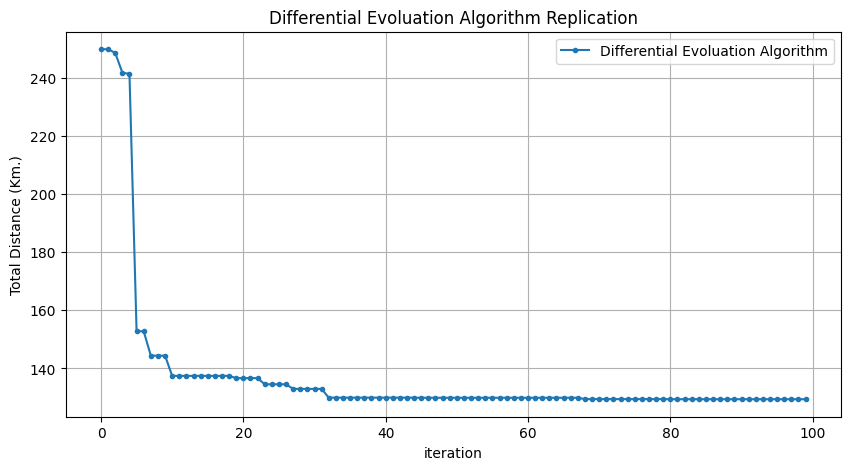

In [60]:
Replication = [i for i in range(len(global_solution_plot))]
y1 = global_solution_plot.tolist()
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(Replication, y1, marker=".", label="Differential Evoluation Algorithm")
ax.set(
    xlabel="iteration",
    ylabel="Total Distance (Km.)",
    title="Differential Evoluation Algorithm Replication",
)
ax.grid()
ax.legend()
plt.show()